In [1]:
import copy
import hypernetx as hnx
import itertools

#The traditional 2-dimensional Mapper (the Mapper graph) is a simplicial complex formed by performing clustering on
#portions of the data space, resulting in a collection of nodes each with some of the data points assigned to them
#(the contents of the node). Unlike a traditional clustering algorithm, however, the partial clustering method can
#cluster a single data point into multiple nodes. To reflect this, a 1-simplex (an edge) is added to the graph
#connecting any pair of nodes which have a non-empty intersection of assigned data points. We assign the intersection
#of those data points to the edge as its contents. This results in a graph which can be used to visualize (and conduct
#a more sophisticated examination of) the data's structure.

#This process can be extended to higher-dimensional simplices: a trio of nodes with a non-empty intersection is
#assigned a 2-simplex (a filled-in triangle) connecting the three nodes, with the three pairwise intersections between
#the three nodes forming the edges of the triangle, a quartet of nodes with non-empty intersection produces a
#tetrahedron, and so on. This process, however, produces a structure that isn't a graph and is not easilly visualizable.
#In addition, the calculations can be taxing. In practice, we often restrict ourselves to the Mapper graph.

#A simplicial complex is, however, an instance of a hypergraph with the additional restriction that if a set of n nodes
#are connected by an edge, all subsets of those nodes are also connected by an edge. The hypernetx package gives tools
#for the analysis and visualization of hypergraphs, which allows us to use the same tools to analyze simplicial
#complexes.

#These functions take a dictionary with node names as keys and sets of data points as values and calculate the
#resulting hypergraph. They then give methods to visualize the hypergraph through the hypernetx package.

#We calculate the hypergraph by use of a simplex tree. The simplex tree has a root node, then has a node for each 0-
#simplex in the hypergraph as a decendent of the root node. Each 0-simplex has children for each edge connecting that
#simplex to a higher-indexed simplex. Thus if there is an edge (node_0,node_1), the 0-simplex "node_0" will have a
#child named "node_1" representing that edge. Likewise, each edge has a child for each 2-simplex for which that edge
#connects the two lowest-indexed nodes forming the triangle (that is, triangle (node_0,node_1,node_2) would be
#represented by giving the node representing the edge (node_0,node_1) a child named "node_2"). In general, an n-
#simplex is represented by giving the (n-1)-simplex connecting all but its highest-indexed node a child named for the
#highest-indexed node.

#We build our simplex tree from the root up. We add all the Mapper's nodes immediately, then sweep through all pairs
#of a node with another, higher-indexed nodes looking for edges. For higher-dimensional simplices, we note that an n-
#simplex exists if and only if the (n-2)-simplex connecting its (n-2) lowest-indexed nodes exists, that simplex has
#children named after the two highest-indexed nodes in the proposed n-simplex, and those two children have a non-empty
#intersection. That is, the simplex (1,2,...,n-2,n-1,n) exists if and only if the simplex (1,2,...,n-2) exists and 
#has children (1,2,...,n-2,n-1) and (1,2,...,n-2,n), and those two simplices have a non-empty intersection. Thus once
#we have all (n-1) simplices constructed, we can construct all n-simplices by searching each (n-2)-simplex's children
#for interesections between a child and one of its higher-indexed siblings. Since we can generate the root node and
#all 0-simplices directly, iterating through this process until no new simplices are generated will form the full
#simplicial complex.

#This process should be as efficient as possible for calculating a Mapper hypergraph.

class Node:
    def __init__(self, parent, name, contents, lineage):
        self.parent=parent
        self.name=name
        self.children=[]
        self.child_names=[]
        self.contents=contents
        self.lineage=lineage
        self.leaf=0
    def Add_Child(self, name, contents):
        lineage=[item for item in self.lineage]
        lineage.append(name)
        child=Node(parent=self, name=name, contents=contents, lineage=lineage)
        self.children.append(child)
        self.child_names.append(name)
        
#Given a dictionary with Mapper node names as keys and sets of data points as values, Build_simplex_Tree builds a
#simplex tree of the simplicial complex generated by the Mapper. It returns the Root node, which contains pointers to
#all of its children.
def Build_Simplex_Tree(Mapper_Node_Dict):
    """Take dictionary of Mapper nodes to included data points, return simplex tree of Mapper hypergraph."""
    Leaves=[]
    Root=Node(parent=None,name='root',contents=None,lineage=[])
    for node in Mapper_Node_Dict.keys():
        Root.Add_Child(name=node,contents=Mapper_Node_Dict[node])
    List=[Root]
    #List is a list of nodes whose children still need to be searched for non-empty intersections
    while List:
        #While List is nonempty
        Parent_Node=List[0]
        Search_List=Parent_Node.children
        index=0
        while index<len(Search_List):
            #This loop searches through the list of children of the first node in Lisst
            Search_Node=Search_List[index]
            for Sibling in Search_List[index+1::]:
                #Compares one child with all highre-indexed siblings, adding non-empty intersections as children of the
                #lower-indexed child
                child_contents=Search_Node.contents.intersection(Sibling.contents)
                if child_contents:
                    Search_Node.Add_Child(name=Sibling.name,contents=child_contents)
            #If the node has multiple children, it may have further simplices as descendents, and so is added to List
            if len(Search_Node.children)>1:
                List.append(Search_Node)
            #If the node has only one child, that child is a leaf
            elif len(Search_Node.children)==1:
                Search_Node.children[0].leaf=1
                Leaves.append(Search_Node.children[0])
            #Otherwise, the node has no children and is thus a leaf itself
            else:
                Search_Node.leaf=1
                Leaves.append(Search_Node)
            index+=1
        del List[0]
    #Returns the Root node (which links to its descendents) and the list of leaf nodes
    return Root, Leaves

def Find_Max_Leaves(Leaves):
    """Take list of leaves in simplex tree, return list of leaves representing maximal simplices."""
    Max_Leaves=[]
    for i in range(len(Leaves)):
        #Iterates through all pairs of leaves in the simplex tree, recording leaves which don't represent proper
        #sub-faces of any other simplex
        leaf=Leaves[i]
        found=0
        for j in range(len(Leaves)):
            if i!=j:
                match=Leaves[j]
                if set(leaf.lineage).issubset(set(match.lineage)):
                    found=1
        if found==0:
            Max_Leaves.append(leaf)
                
    return Max_Leaves
        

def Build_Hypergraph(Root_Node, Max_Leaves=None):
    """Take root of simplex tree as Root_Node, optionally list of maximal simplices as Max_Leaves, return hypergraph with all edges (if Max_Leaves is None) or edges repressenting maximal leaves (otherwise)."""
    i=1
    #i is an index variable
    hypergraph={}
    #hypergraph records edges to turn into a hypergraph object
    if Max_Leaves==None:
        #If Max_Leaves==None, the function includes all edges in the hypergraph
        List=[Root_Node]
        while List:
            #Iterates through all nodes in simplex tree, recording represented simplices as hypergraph edges
            if len(List[0].lineage)>1:
                hypergraph[i]=List[0].lineage
                i+=1
            List.extend(List[0].children)
            List=List[1::]
    else:
        #If Max_Leaves is a list of maximal leaves, records only the maximal simplices as edges. All other edges follow
        #from simplicial complex including sub-faces
        List=Max_Leaves
        for leaf in Max_Leaves:
            hypergraph[i]=leaf.lineage
            i+=1
            
    #Returns the recorded edge list as a hypergraph object
    return hnx.Hypergraph(hypergraph)

def Build_Hypergraph_From_Dict(Mapper_Node_Dict,draw=False):
    """Take dictionary of Mapper nodes to included data points and optional True/False toggle draw, return root node of simplex tree as Root, hypergraph depiction of simplex tree as Hypergraph, and draw Hypergraph if draw is True."""
    #Wrapper for Hypergraph functions
    Root,Leaves=Build_Simplex_Tree(Mapper_Node_Dict)
    Max_Leaves=Find_Max_Leaves(Leaves)
    Hypergraph=Build_Hypergraph(Root,Max_Leaves=Max_Leaves)
    if draw:
        hnx.drawing.draw(Hypergraph)
    return Root,Hypergraph
        

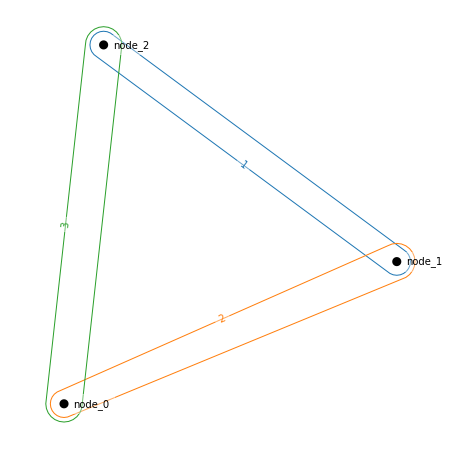

In [2]:
Mapper_Node_Dict={'node_0':{0,1},'node_1':{1,2},'node_2':{2,0}}

Root,Hypergraph=Build_Hypergraph_From_Dict(Mapper_Node_Dict,draw=True)